In [307]:
!pip install pandasql
import numpy as np
from pandasql import sqldf
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import lxml
import openpyxl
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from matplotlib import pyplot


In [364]:
team_data = pd.read_excel(r"C:\Users\sdarvish\Downloads\Data Challenge Master File.xlsx", sheet_name='Team Data')
ucp_member = pd.read_excel(r"C:\Users\sdarvish\Downloads\Data Challenge Master File.xlsx", sheet_name='UCP Member Report')
ucp_res = pd.read_excel(r"C:\Users\sdarvish\Downloads\Data Challenge Master File.xlsx", sheet_name='UCP Reservations')
ucp_scans = pd.read_excel(r"C:\Users\sdarvish\Downloads\Data Challenge Master File.xlsx", sheet_name='UCP Scans')
singles = pd.read_excel(r"C:\Users\sdarvish\Downloads\Data Challenge Master File.xlsx", sheet_name='Single Game Sales and Scans')

In [296]:
r = requests.get("https://www.basketball-reference.com/teams/LAC/2023_games.html")
soup=bs(r.content)
table = soup.select('table#games')[0]
columns = table.find('thead').find_all('th')
schedule = pd.read_html(str(table))[0]


In [180]:
active_accts=sqldf("""select distinct tenant_member_number from ucp_member where account_status = 'ACTIVE'""")
#408 accts
inactive_accts=sqldf("""select distinct tenant_member_number from ucp_member where account_status != 'ACTIVE'""")
#169
# Predicting attendance based on season averages
ucp_scans_by_game =sqldf("""select event_date, count(*) as scans from ucp_scans group by event_date""")
ucp_avg_scans = sqldf("""select avg(scans) as proj_attend from ucp_scans_by_game""")
#223.18 attends based on ucp attend average over season

In [ ]:
# could be added below                       julianday(b.event_date) - julianday(reserved_at) as reserved,

In [509]:
ucp_join=sqldf("""select a.*,
                        julianday('now') - julianday(member_since) as tenure,
                        julianday('now') - julianday(birthdate) as age,
                        b.ticket_id,
                        b.event_name,
                        b.event_date_local as hour_of_day,
                        b.event_date as day_of_week,
                        b.event_date as month_of_year,
                        b.section,
                        b.row,
                        b.seat,
                        b.reserved_at,
                        c.scan_datetime,
                        case when c.scan_datetime is not null then 1 else 0 end as scan_flag,
                        case when b.section in (316, 317, 318, 319, 320, 301, 302, 303, 333, 334) then 'sideline'
                                when b.section in (313, 314, 315, 321, 322, 323, 332, 331, 330, 304, 305,306) then 'elbow'
                                when b.section in (307, 308, 309, 310, 311, 312, 324, 325, 326, 327, 328, 329) then 'baseline'
                                else ' ' end as section1
                from ucp_member as a
                    left join ucp_res as b
                        on a.tenant_member_number = b.tenant_member_number
                    left join ucp_scans as c 
                         on b.event_date = c.event_date
                         and b. section = c.section_name
                         and b.row = c.row_name
                         and b.seat = c.seat_number""")

In [510]:
billing_interval1 = pd.get_dummies(ucp_join['BILLING_INTERVAL'],drop_first=True)
account_status = pd.get_dummies(ucp_join['ACCOUNT_STATUS'],drop_first=True)
section2 = pd.get_dummies(ucp_join['section1'],drop_first=True)
event_dates = pd.to_datetime(ucp_join['day_of_week'])
event_months = pd.to_datetime(ucp_join['month_of_year'])
event_date_locals = pd.to_datetime(ucp_join['hour_of_day'])
day_of_week = event_dates.dt.dayofweek
month_of_year = event_months.dt.month
hour_of_day = event_date_locals.dt.hour
ucp_join.drop(['TENANT_MEMBER_NUMBER', 'ACCOUNT_STATUS', 'MEMBER_SINCE', 'BIRTHDATE', 'BILLING_INTERVAL',
               'TICKET_ID', 'EVENT_NAME', 'hour_of_day', 'day_of_week', 'month_of_year', 'SECTION', 'ROW', 'SEAT',
               'RESERVED_AT', 'scan_datetime', 'section1'], axis = 1, inplace=True)


In [511]:

#ucp_join = pd.concat([ucp_join, account_status, billing_interval1, day_of_week, month_of_year, hour_of_day, section2], axis=1)
ucp_join = pd.concat([ucp_join, account_status, billing_interval1, day_of_week, month_of_year, hour_of_day], axis=1)
ucp_join = ucp_join.dropna()
scan_flag1=ucp_join.scan_flag
ucp_join.drop(['scan_flag'], axis=1, inplace=True)
df_scale = (ucp_join-ucp_join.min())/(ucp_join.max()-ucp_join.min())
df_scale.drop(['EXPIRED'], axis=1, inplace=True)

In [512]:
X_train, X_test, y_train, y_test = train_test_split(df_scale, scan_flag1, test_size=0.3, random_state=0)

#X_train
X_test

,tenure,age,CANCELLED,DUNNING,MONTHLY,day_of_week,month_of_year,hour_of_day
5244,0.630769,0.492837,0.0,0.0,1.0,0.333333,0.090909,1.000000
5484,0.638462,0.229845,0.0,0.0,1.0,0.666667,0.909091,1.000000
1922,0.497436,0.481431,0.0,0.0,1.0,0.500000,0.181818,1.000000
2277,0.517949,0.355185,1.0,0.0,1.0,0.500000,1.000000,1.000000
5602,0.638462,0.244842,0.0,0.0,1.0,0.500000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
4466,0.612821,0.353877,0.0,0.0,1.0,0.833333,1.000000,0.142857
4433,0.610256,0.325393,0.0,0.0,0.0,0.166667,0.000000,1.000000
5356,0.635897,0.276277,0.0,0.0,1.0,0.833333,0.909091,1.000000
3446,0.556410,0.281545,0.0,0.0,0.0,0.333333,1.000000,1.000000


In [513]:

log_model = LogisticRegression(class_weight='balanced')
log_model.fit(X_train, y_train)
predictions_log = log_model.predict(X_test)
predictions_log.shape

(1926,)

,tenure,age,CANCELLED,DUNNING,EXPIRED,MONTHLY,day_of_week,month_of_year,hour_of_day


In [515]:
print(classification_report(y_test, predictions_log))

              precision    recall  f1-score   support

           0       0.35      0.59      0.44       619
           1       0.72      0.49      0.58      1307

    accuracy                           0.52      1926
   macro avg       0.53      0.54      0.51      1926
weighted avg       0.60      0.52      0.54      1926



In [516]:
importance = log_model.coef_.flatten()

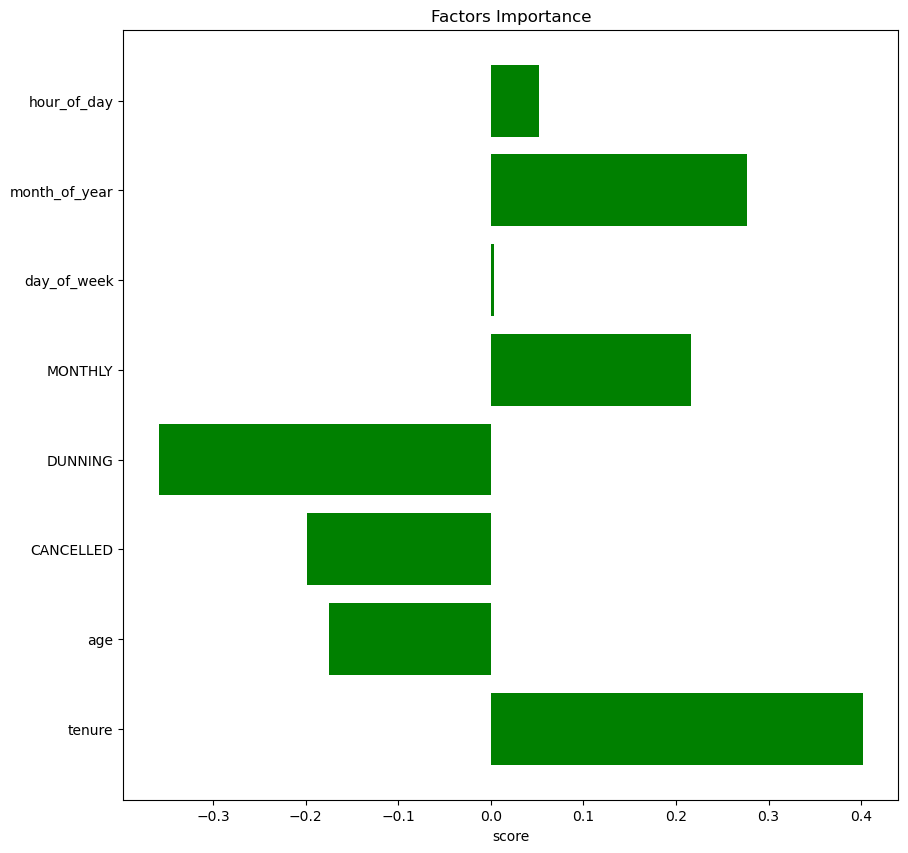

In [556]:
pyplot.rcParams["figure.figsize"] = (10,10)
pyplot.barh(df_scale.columns, importance, color='g')
pyplot.title('Factors Importance')
pyplot.xlabel('score')
pyplot.show()

In [550]:
ucp_pred=sqldf("""select distinct account_status, member_since, birthdate, billing_interval,
                        julianday('now') - julianday(member_since) as tenure,
                        julianday('now') - julianday(birthdate) as age from ucp_member""")
billing_interval1 = pd.get_dummies(ucp_pred['BILLING_INTERVAL'],drop_first=True)
account_status = pd.get_dummies(ucp_pred['ACCOUNT_STATUS'],drop_first=True)
ucp_pred.drop(['ACCOUNT_STATUS', 'MEMBER_SINCE', 'BIRTHDATE', 'BILLING_INTERVAL'], axis = 1, inplace=True)
ucp_pred = pd.concat([ucp_pred, account_status, billing_interval1], axis=1)
ucp_pred = ucp_pred.dropna()

In [551]:
ucp_pred = sqldf("""select tenure, age, CANCELLED, DUNNING, MONTHLY from ucp_pred""")
pred_scale = (ucp_pred-ucp_pred.min())/(ucp_pred.max()-ucp_pred.min())

In [552]:
pred_scale=sqldf("""select *, 0.833333 as day_of_week, .242424 as month_of_year, 1 as hour_of_day from pred_scale""")

In [553]:
predictions_log_real = log_model.predict(pred_scale)

In [554]:
predictions_log_real

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,

In [555]:
def _sum(predictions_log_real):
 
    # initialize a variable
    # to store the sum
    # while iterating through
    # the array later
    sum = 0
 
    # iterate through the array
    # and add each element to the sum variable
    # one at a time
    for i in predictions_log_real:
        sum = sum + i
 
    return(sum)
 
 
# main function
if __name__ == "__main__":
 
    # calculating length of array
    n = len(predictions_log_real)
    # calling function ans store the sum in ans
    ans = _sum(predictions_log_real)
    # display sum
    print('Sum of the array is ', ans)

Sum of the array is  155


In [537]:
pred_scale
#1) [SQL] Do evening games (6:00pm or later) on average, have a higher scanned attendance than afternoon
#games (Before 6:00pm)? Also, provide average attendance per game by month.

,tenure,age,CANCELLED,DUNNING,MONTHLY,day_of_week,month_of_year,hour_of_day
0,0.000000,0.511524,0.0,0.0,0.0,NaN,NaN,NaN
1,0.045802,0.340121,0.0,0.0,1.0,NaN,NaN,NaN
2,0.050891,0.630053,0.0,0.0,0.0,NaN,NaN,NaN
3,0.055980,0.242795,0.0,0.0,1.0,NaN,NaN,NaN
4,0.055980,0.240749,0.0,0.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
554,0.994911,0.408964,0.0,0.0,0.0,NaN,NaN,NaN
555,0.997455,0.347536,0.0,0.0,0.0,NaN,NaN,NaN
556,0.997455,0.347536,0.0,0.0,1.0,NaN,NaN,NaN
557,1.000000,0.443822,0.0,0.0,0.0,NaN,NaN,NaN


In [230]:
hour = pd.to_datetime(ucp_scans['event_datetime'])
hour_of_day1 = hour.dt.hour
ucp_scans_q1 = pd.concat([ucp_scans, hour_of_day1], axis=1)
ucpq1=sqldf("""select count(scan_datetime) as attends,
                case when event_datetime >= 18 then 1 
                    else 0 end as evening_game_flag,
                    event_date
        from ucp_scans_q1
        group by event_date""")

,attends,evening_game_flag,event_date
0,244,1,2022-10-23 00:00:00.000000
1,194,0,2022-10-30 00:00:00.000000
2,91,1,2022-10-31 00:00:00.000000
3,136,1,2022-11-06 00:00:00.000000
4,179,1,2022-11-07 00:00:00.000000
5,234,0,2022-11-12 00:00:00.000000
6,126,1,2022-11-17 00:00:00.000000
7,120,1,2022-11-19 00:00:00.000000
8,128,1,2022-11-21 00:00:00.000000
9,179,1,2022-11-25 00:00:00.000000


In [265]:
singlesq1=sqldf("""select count(scan_datetime) as attends,
                    event_name
        from singles
        group by event_name
        order by event_datetime""")

TypeError: 'str' object is not callable

In [244]:
#2) [SQL] Count the number of UCP members with reservations >=5 and scans >=3. Of these, 
#    how many UCP members attended every game they reserved?
#NOTE: TENANT MEMBER NUMBER: 1000-000-0000 represent ticket add-ons and can be dropped from this question

In [279]:
q2=sqldf("""select tenant_member_number,
                count(reserved_at) as num_reservations,
                count(scan_datetime) as num_scans
            from ucp_res a
                    left join ucp_scans as b 
                         on a.event_date = b.event_date
                         and a.section = b.section_name
                         and a.row = b.row_name
                         and a.seat = b.seat_number
            where tenant_member_number !='1000-000-0000'
            group by tenant_member_number""")

In [281]:
num_accounts=sqldf("""select count(*) as num_accounts
          from q2
          where num_reservations >= 5
          and num_scans >= 3""")

,num_accounts
0,330


In [282]:
perf_attend=sqldf("""select count(*) as num_accounts
          from q2
          where num_reservations >= 5
          and num_scans >= 3
          and num_reservations = num_scans""")

,num_accounts
0,26


In [285]:
sqldf("""select count(distinct tenant_member_number)  from ucp_member where tenant_member_number !='1000-000-0000'""")

,count(distinct tenant_member_number)
0,577


In [ ]:
#3)[SQL] Find the average cost of a single game ticket for each game in the dataset provided.
#Then compare the total value if all UCP eligible games were purchased at their average single game price,
#against the UCP package price. Assume the UCP package price is $350.
#NOTE: G41 vs POR can be excluded from the single game total calculation.

In [289]:
sqldf("""select event_name, avg(price) from singles group by event_name order by event_datetime""")

,event_name,avg(price)
0,LA Clippers 2022-23 Game 1 - Phoenix 10/23/22,31.966790
1,LA Clippers 2022-23 Game 2 - New Orleans 10/30/22,25.443343
2,LA Clippers 2022-23 Game 3 - Houston 10/31/22,17.791587
3,LA Clippers 2022-23 Game 4 - Utah 11/6/22,17.300654
4,LA Clippers 2022-23 Game 5 - Cleveland 11/7/22,18.935616
5,LA Clippers 2022-23 Game 6 - Los Angeles 11/9/22,78.283906
6,LA Clippers 2022-23 Game 7 - Brooklyn 11/12/22,36.816234
7,LA Clippers 2022-23 Game 8 - Detroit 11/17/22,16.307390
8,LA Clippers 2022-23 Game 9 - San Antonio 11/19/22,17.350417
9,LA Clippers 2022-23 Game 10 - Utah 11/21/22,19.911941


In [290]:
#4) Pull data from Basketball Reference around 22/23 game schedule. Is there a difference in reservations 
#and scans for UCP members and single game buyers during homestands where LAC plays 3 or more consecutive
#home games (ie: no road games in between), vs all other games? Optional: Include code for scraping Basketball 
#Reference and pulling in data.
#a. Hint: LAC had seven homestands of at least three games last season. You will be analyzing the 
#reservations/sales/scans of all games in those seven homestands, compared to the remaining games.


,event_name,avg(price)
0,LA Clippers 2022-23 Game 1 - Phoenix 10/23/22,31.966790
1,LA Clippers 2022-23 Game 2 - New Orleans 10/30/22,25.443343
2,LA Clippers 2022-23 Game 3 - Houston 10/31/22,17.791587
3,LA Clippers 2022-23 Game 4 - Utah 11/6/22,17.300654
4,LA Clippers 2022-23 Game 5 - Cleveland 11/7/22,18.935616
5,LA Clippers 2022-23 Game 6 - Los Angeles 11/9/22,78.283906
6,LA Clippers 2022-23 Game 7 - Brooklyn 11/12/22,36.816234
7,LA Clippers 2022-23 Game 8 - Detroit 11/17/22,16.307390
8,LA Clippers 2022-23 Game 9 - San Antonio 11/19/22,17.350417
9,LA Clippers 2022-23 Game 10 - Utah 11/21/22,19.911941


In [356]:
ucpq4=sqldf(""" select *  from ucp_res a
                    full join ucp_scans as b 
                         on a.event_date = b.event_date
                         and a.section = b.section_name
                         and a.row = b.row_name
                         and a.seat = b.seat_number""")

sqldf(""" select event_name, event_date, count(reserved_at) as num_reservations, count(scan_datetime) as num_scans
            from ucpq4
            where event_name is not null
            group by event_name, event_date
            order by event_date""")

,EVENT_NAME,event_date,num_reservations,num_scans
0,Suns @ Clippers,2022-10-23 00:00:00.000000,281,244
1,Pelicans @ Clippers,2022-10-30 00:00:00.000000,252,194
2,Rockets @ Clippers,2022-10-31 00:00:00.000000,153,91
3,Jazz @ Clippers,2022-11-06 00:00:00.000000,194,136
4,Cavaliers @ Clippers,2022-11-07 00:00:00.000000,223,179
5,Nets @ Clippers,2022-11-12 00:00:00.000000,300,234
6,Pistons @ Clippers,2022-11-17 00:00:00.000000,177,126
7,Spurs @ Clippers,2022-11-19 00:00:00.000000,176,120
8,Jazz @ Clippers,2022-11-21 00:00:00.000000,180,128
9,Nuggets @ Clippers,2022-11-25 00:00:00.000000,245,179


In [361]:
sqldf(""" select event_name, count(sale_datetime) as num_sales, count(scan_datetime) as num_scans
            from singles 
            group by event_name
            order by event_datetime""")

,event_name,num_sales,num_scans
0,LA Clippers 2022-23 Game 1 - Phoenix 10/23/22,2651,2574
1,LA Clippers 2022-23 Game 2 - New Orleans 10/30/22,1352,1255
2,LA Clippers 2022-23 Game 3 - Houston 10/31/22,523,457
3,LA Clippers 2022-23 Game 4 - Utah 11/6/22,1071,988
4,LA Clippers 2022-23 Game 5 - Cleveland 11/7/22,1218,1144
5,LA Clippers 2022-23 Game 6 - Los Angeles 11/9/22,4250,4087
6,LA Clippers 2022-23 Game 7 - Brooklyn 11/12/22,2501,2368
7,LA Clippers 2022-23 Game 8 - Detroit 11/17/22,866,722
8,LA Clippers 2022-23 Game 9 - San Antonio 11/19/22,1440,1309
9,LA Clippers 2022-23 Game 10 - Utah 11/21/22,1623,1538


In [345]:
q4=sqldf(""" select *, 
                case when G in (10,11,12,13,16,17,18,29,30,31,32,33,
                                42,43,44,45,46,58,59,60,67,68,69,70,71,73,74,75,76) then 1 
                else 0 end as homestand_flag
            from schedule where G != 'G'""")
date_format = "%a, %b %d, %Y"
datetime_objects = q4['Date'].apply(lambda x: datetime.strptime(x, date_format))
q4['Datetime'] = datetime_objects


In [346]:
q4=sqldf("""select *, julianday(Datetime) as datetime1 from q4""")


In [349]:
sqldf("""select a.*, homestand_flag 
            from singlesq4 as a
                left join q4 as b
                    on a.event_datetime1 = b.datetime1""")

,event_datetime,event_name,ticket_id,section_name,row_name,seat_number,account_id,price,sale_datetime,scan_datetime,event_datetime1,homestand_flag
0,2023-03-25 19:30:00.000000,LA Clippers 2022-23 Game 38 - New Orleans 3/25/23,9000000150774457,324,3,4,9000000038429857,30.00,2022-12-22 18:29:15.000000,2023-03-25 20:43:54.000000,2.460029e+06,None
1,2022-11-09 19:00:00.000000,LA Clippers 2022-23 Game 6 - Los Angeles 11/9/22,9000000147209138,313,8,6,9000000034678303,42.00,2022-12-27 17:50:31.000000,2022-11-09 20:57:06.000000,2.459893e+06,None
2,2022-11-09 19:00:00.000000,LA Clippers 2022-23 Game 6 - Los Angeles 11/9/22,9000000146110384,317,8,12,9000000034604271,89.00,2022-12-27 17:47:03.000000,2022-11-09 21:17:08.000000,2.459893e+06,None
3,2022-11-09 19:00:00.000000,LA Clippers 2022-23 Game 6 - Los Angeles 11/9/22,9000000147210048,332,14,9,9000000034000724,49.00,2022-12-27 17:52:39.000000,2022-11-09 21:19:38.000000,2.459893e+06,None
4,2022-11-09 19:00:00.000000,LA Clippers 2022-23 Game 6 - Los Angeles 11/9/22,9000000141813929,302,9,19,9000000004648906,44.00,2022-12-27 17:36:55.000000,2022-11-09 21:23:31.000000,2.459893e+06,None
...,...,...,...,...,...,...,...,...,...,...,...,...
83522,2023-01-08 18:00:00.000000,LA Clippers 2022-23 Game 20 - Atlanta 1/8/23,9000000150929382,308,7,5,9000000024983766,17.00,2023-02-07 15:04:04.000000,None,2.459953e+06,None
83523,2023-01-08 18:00:00.000000,LA Clippers 2022-23 Game 20 - Atlanta 1/8/23,9000000150929461,312,5,5,9000000032529939,55.42,2023-02-07 15:04:04.000000,None,2.459953e+06,None
83524,2022-11-09 19:00:00.000000,LA Clippers 2022-23 Game 6 - Los Angeles 11/9/22,9000000147209469,316,8,7,9000000034339412,57.00,2022-12-27 17:50:58.000000,None,2.459893e+06,None
83525,2022-11-25 19:30:00.000000,LA Clippers 2022-23 Game 11 - Denver 11/25/22,9000000146888358,311,6,19,9000000024252246,22.00,2022-12-27 18:41:52.000000,None,2.459909e+06,None


In [348]:
q4

,G,Date,Start (ET),Unnamed: 3,Unnamed: 4,Unnamed: 5,Opponent,Unnamed: 7,Unnamed: 8,Tm,Opp,W,L,Streak,Notes,Datetime,homestand_flag,datetime1
0,1,"Thu, Oct 20, 2022",10:00p,None,Box Score,@,Los Angeles Lakers,W,None,103,97,1,0,W 1,None,2022-10-20 00:00:00.000000,0,2459872.5
1,2,"Sat, Oct 22, 2022",10:00p,None,Box Score,@,Sacramento Kings,W,None,111,109,2,0,W 2,None,2022-10-22 00:00:00.000000,0,2459874.5
2,3,"Sun, Oct 23, 2022",10:00p,None,Box Score,None,Phoenix Suns,L,None,95,112,2,1,L 1,None,2022-10-23 00:00:00.000000,0,2459875.5
3,4,"Tue, Oct 25, 2022",8:00p,None,Box Score,@,Oklahoma City Thunder,L,None,94,108,2,2,L 2,None,2022-10-25 00:00:00.000000,0,2459877.5
4,5,"Thu, Oct 27, 2022",8:00p,None,Box Score,@,Oklahoma City Thunder,L,None,110,118,2,3,L 3,None,2022-10-27 00:00:00.000000,0,2459879.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,78,"Fri, Mar 31, 2023",8:00p,None,Box Score,@,Memphis Grizzlies,L,None,94,108,41,37,L 1,None,2023-03-31 00:00:00.000000,0,2460034.5
78,79,"Sat, Apr 1, 2023",8:30p,None,Box Score,@,New Orleans Pelicans,L,None,114,122,41,38,L 2,None,2023-04-01 00:00:00.000000,0,2460035.5
79,80,"Wed, Apr 5, 2023",10:00p,None,Box Score,None,Los Angeles Lakers,W,None,125,118,42,38,W 1,None,2023-04-05 00:00:00.000000,0,2460039.5
80,81,"Sat, Apr 8, 2023",4:00p,None,Box Score,None,Portland Trail Blazers,W,None,136,125,43,38,W 2,None,2023-04-08 00:00:00.000000,0,2460042.5


In [ ]:
#LSTM Model to predict UCP scans for last game

In [443]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import datetime
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [444]:
df=sqldf("""select count(scan_datetime) as scans from ucp_scans group by event_date order by event_date""")
#df['index_col'] = df.index

In [445]:
steps = 5

x_train = []
y_train = []
x_game_wut = []
y_game_wut = []

#event_list = df.index_col.unique()
#for event_date in event_list:
#    df2=df.loc[df['index_col'] == event_date]
for i in range(steps, df.shape[0]-steps):
    x_train.append(df.iloc[i-steps:i,:])
    y_train.append(df.iloc[i,:])
    #    if event_id == 18020:
     #       x_game_wut.append(df2.iloc[i-steps:i,1:])
      #      y_game_wut.append(df2.iloc[i,1:])

In [446]:
X = np.array(x_train)
Y = np.array(y_train)

In [447]:
lengthy = int(len(x_train)*.8)

X_train = X[:lengthy, :]
X_test = X[lengthy:, :]

y_train = Y[:lengthy, :]
y_test = Y[lengthy:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (19, 5, 1) (19, 1)
Testing Shape (5, 5, 1) (5, 1)


In [448]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
#X_test_wut_tensors = Variable(torch.Tensor(X_wut))
#print(X_test_wut_tensors_final.shape)
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 
#y_test_wut_tensors = Variable(torch.Tensor(Y_wut)) 

In [449]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([19, 1, 5]) torch.Size([19, 1])
Testing Shape torch.Size([5, 1, 5]) torch.Size([5, 1])


In [450]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
    
num_epochs = 6000 #1000 epochs
learning_rate = 0.0015 #0.001 lr og

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [451]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 20297.99023
Epoch: 100, loss: 18969.03711
Epoch: 200, loss: 16276.98535
Epoch: 300, loss: 12553.59375
Epoch: 400, loss: 8666.67285
Epoch: 500, loss: 5423.99609
Epoch: 600, loss: 3263.34961
Epoch: 700, loss: 2140.02637
Epoch: 800, loss: 1695.07166
Epoch: 900, loss: 1561.54358
Epoch: 1000, loss: 1530.64221
Epoch: 1100, loss: 1524.96484
Epoch: 1200, loss: 1524.11621
Epoch: 1300, loss: 1524.01172
Epoch: 1400, loss: 1524.00098
Epoch: 1500, loss: 1524.00024
Epoch: 1600, loss: 1524.00024
Epoch: 1700, loss: 1524.00012
Epoch: 1800, loss: 1524.00012
Epoch: 1900, loss: 1524.00000
Epoch: 2000, loss: 1524.00000
Epoch: 2100, loss: 1524.00000
Epoch: 2200, loss: 1524.00000
Epoch: 2300, loss: 1524.00000
Epoch: 2400, loss: 1524.00012
Epoch: 2500, loss: 1524.00000
Epoch: 2600, loss: 1524.00012
Epoch: 2700, loss: 1524.00000
Epoch: 2800, loss: 1524.00000
Epoch: 2900, loss: 1524.00000
Epoch: 3000, loss: 1524.00000
Epoch: 3100, loss: 1524.00000
Epoch: 3200, loss: 1523.99988
Epoch: 3300, loss:

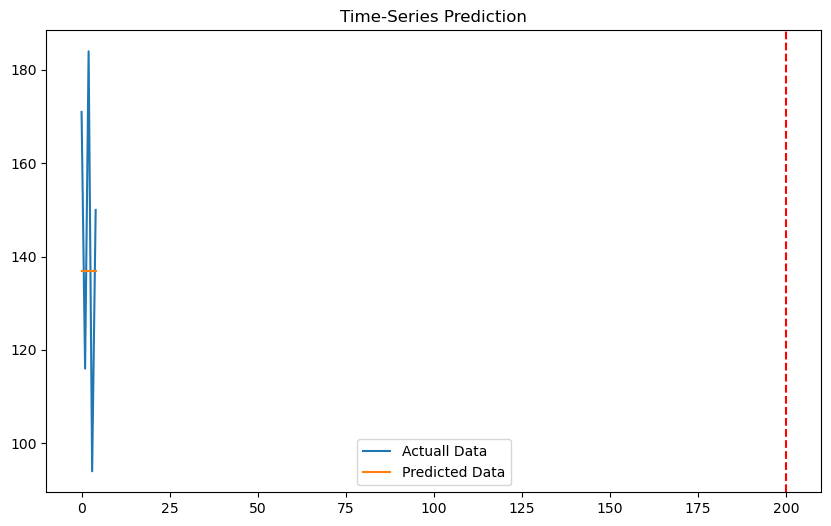

In [452]:
train_predict = lstm1(X_test_tensors_final)#X_test_tensors_final)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_test_tensors.data.numpy()

# data_predict = mm.inverse_transform(data_predict) #reverse transformation
# dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 